In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
device = 'cuda'
model_checkpoint = "roberta-base"

## Exploring the data

In [3]:
import pandas as pd

In [4]:
raw_train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
raw_test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [5]:
len(raw_train_df)

7613

In [6]:
raw_train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
raw_test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
duplicates_df = raw_train_df[raw_train_df.text.duplicated(keep=False)].sort_values('text')
duplicates_df.head()

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6363,9095,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1


## Clean the data

As we've seen, there are dosens of duplicated tweets. Moreover, their labes are sometimes contradictory.

In [9]:
duplicates_df[:20]

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it...,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6363,9095,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6377,9113,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6378,9114,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
2828,4064,displaced,NaN,#KCA #VoteJKT48ID 12News: UPDATE: A family of ...,1


In [10]:
duplicated_tweets = list(duplicates_df.text)

In [11]:
len(duplicated_tweets)

179

Now search for contradictions

In [12]:
contradictory_tweets = set()
for tweet in duplicated_tweets:
    if len(set(duplicates_df[duplicates_df['text'] == tweet].target)) > 1:
        contradictory_tweets.add(tweet)

contradictory_tweets = list(contradictory_tweets)
print(len(contradictory_tweets), type(contradictory_tweets))

18 <class 'list'>


We're going to label those manually

In [13]:
for i, tweet in enumerate(contradictory_tweets):
    print(i, tweet, '\n')

0 I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ?????? 

1 Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam! 

2 .POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4 

3 RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG 

4 #foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption 

5 #Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect 

6 Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh... 

7 The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.' 

8 like for the music video I want some real action shit like burning buildings and 

In [14]:
no_duplicates_train_df = raw_train_df.drop_duplicates('text')
print(len(no_duplicates_train_df))

7503


In [15]:
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[0], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[1], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[2], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[3], 'target'] = 0 
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[4], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[5], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[6], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[7], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[8], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[9], 'target'] = 1
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[10], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[11], 'target'] = 1
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[12], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[13], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[14], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[15], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[16], 'target'] = 0
no_duplicates_train_df.loc[no_duplicates_train_df['text'] == contradictory_tweets[17], 'target'] = 1

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Create the Datasets

In [16]:
import torch
from torch.utils.data import Dataset
from transformers import RobertaTokenizer,RobertaModel

from tqdm import tqdm
from copy import deepcopy
import random

In [17]:
tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint)

In [18]:
class LabeledDisasterTweetsDataset(Dataset):
    def __init__(self, 
                 df, 
                 tokenizer, 
                 max_tweet_len=256, 
                 tweet_column='text',
                 location_column='location', 
                 keyword_column='keyword', 
                 target_column='target', 
                 device='cpu'):
        
        self._data = []
        
        for index, row in tqdm(df.iterrows(), total=len(df), ncols=70):
            tokenized = tokenizer(row[tweet_column], padding="max_length", truncation=True, max_length=256, return_tensors='pt')
            self._data.append(((tokenized['input_ids'][0].to(device), tokenized['attention_mask'][0].to(device)), torch.tensor(row[target_column]).to(device)))
        
        print('NOTE: you can safely delete the dataframe')
        
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, i):
        """return: ((input_ids, attention_mask), target)"""
        return self._data[i] 
    
    def train_valid_split(self, train_fraction=.9, shuffle=True):
        num_train_examples = int(len(self) * train_fraction)
        
        train_dataset = deepcopy(self)
        
        if shuffle:
            random.shuffle(train_dataset._data)
        
        valid_dataset = deepcopy(train_dataset)
        train_dataset._data = train_dataset._data[:num_train_examples]
        valid_dataset._data = valid_dataset._data[num_train_examples:]
        
        print('NOTE: you can safely delete parent dataset. The train|valid split is {}|{}.'.format(len(train_dataset), len(valid_dataset)))
        
        return train_dataset, valid_dataset
    
    
class UnlabeledDisasterTweetsDataset(Dataset):
    def __init__(self, 
                 df, 
                 tokenizer, 
                 max_tweet_len=256, 
                 tweet_column='text', 
                 id_column='id', 
                 device='cpu'):
        
        self._data = []
        
        for index, row in tqdm(df.iterrows(), total=len(df), ncols=70):
            tokenized = tokenizer(row[tweet_column], padding="max_length", truncation=True, max_length=256, return_tensors='pt')
            self._data.append((torch.tensor(row[id_column]).to(device) ,(tokenized['input_ids'][0].to(device), tokenized['attention_mask'][0].to(device))))
        
        print('NOTE: you can safely delete the dataframe')
        
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self, i):
        """return: (id, (input_ids, attention_mask))"""
        return self._data[i] 

In [19]:
dataset = LabeledDisasterTweetsDataset(no_duplicates_train_df, tokenizer, device=device)

100%|████████████████████████████| 7503/7503 [00:09<00:00, 809.73it/s]

NOTE: you can safely delete the dataframe


In [20]:
train_dataset, valid_dataset = dataset.train_valid_split()

NOTE: you can safely delete parent dataset. The train|valid split is 6752|751.


In [21]:
eval_dataset = UnlabeledDisasterTweetsDataset(raw_test_df, tokenizer, device='cuda')

100%|███████████████████████████| 3263/3263 [00:02<00:00, 1247.23it/s]

NOTE: you can safely delete the dataframe


## Defining the model

In [22]:
class RobertaClassifier(torch.nn.Module):
    def __init__(self, n_classes=2, head_dropout=.5, head_activation=torch.nn.ReLU, model_checkpoint=model_checkpoint):
        super().__init__()
        
        self.Roberta = RobertaModel.from_pretrained(model_checkpoint)
        
        self.Head = torch.nn.Sequential(
            torch.nn.Dropout(head_dropout),
            torch.nn.Linear(768, n_classes)
        )
        
    def forward(self, input_ids, attention_mask=None, *argv):
        res = self.Roberta(input_ids=input_ids, attention_mask=attention_mask)
        res = res['pooler_output']
        res = self.Head(res)
        return res
    
    def parameters_num(self):
        return sum(p.numel() for p in self.parameters())

In [23]:
model = RobertaClassifier()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
model = model.to(device)

In [25]:
model(torch.tensor([[1]], device=device))

tensor([[-0.1073,  0.0455]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [26]:
print('Our Roberta has {:,d} parameters...'.format(model.parameters_num()))

Our Roberta has 124,647,170 parameters...


## Fine-tuning

In [27]:
from torch.utils.data import DataLoader

In [28]:
batch_size = 8

In [29]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [31]:
def train(model, 
          train_dataloader, 
          valid_dataloader, 
          steps, 
          optimizer,
          blind_steps=None,
          loss_fn=torch.nn.BCELoss(),
          main_metric=('f1', f1_score), 
          additional_metrics=[],
          filepath='model_sd.pt',
          load_best=True,
          scheduler=None,
          losses_dict=None):
    
    if blind_steps == None:
        blind_steps = len(train_dataloader) // 4
    
    def evaluate():  # the first score returned is the main
        model.eval()
        
        y_trues = []
        y_hats = []
        
        loss = 0
        k = 0
        
        with torch.no_grad():
            for batch in valid_dataloader:
                
                (ids, mask), y_true = batch
                hots = torch.nn.functional.one_hot(y_true, 2).to(device, torch.float)
                y_hat = torch.softmax(model.forward(input_ids=ids, attention_mask=mask),dim=-1)

                loss += float(loss_fn(y_hat, hots))
                k += 1
                
                for i in range(y_true.shape[0]):
                    y_trues.append(int(y_true[i]))
                    y_hats.append(1 if y_hat[i][0] < y_hat[i][1] else 0)
        
        scores = [(main_metric[0], main_metric[1](y_trues, y_hats))]
        
        for metric in additional_metrics:
            scores.append((metric[0], metric[1](y_trues, y_hats)))        
        
        model.train()
        return scores + [('valid_loss', loss/k)]
    
    
    def render_scores(scores, step, best=None):
        print('{:05d} steps'.format(step), end=' ')
        
        for score in scores:
            print("| {}: {:.3f}".format(*score), end=' ')
            
        if best != None:
            print('| best_score: {:.3f}'.format(best))
            
    
    # initial scores
    scores = evaluate()
    render_scores(scores, 0)
    best_score = scores[0][1]
    torch.save(model.state_dict(), filepath)
    
    # logs
    if losses_dict != None:
        losses_dict['train_loss'] = []
        losses_dict['valid_loss'] = []
    
    epoch_loss = 0
    k = 0
    
    train_iter = iter(train_dataloader)
    model.train()
    
    for step in tqdm(range(steps)):
        
        # retrieving a batch
        try:
            batch = next(train_iter)
        except:
            train_iter = iter(train_dataloader)
            batch = next(train_iter)

        (ids, mask), y_true = batch

        # prediction
        y_hat = torch.softmax(model.forward(input_ids=ids, attention_mask=mask),dim=-1)
        hots = torch.nn.functional.one_hot(y_true, 2).to(device, torch.float)
        loss = loss_fn(y_hat, hots)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if scheduler != None:
            scheduler.step()
            
        epoch_loss += float(loss)
        k+=1
        
        # evaluation
        if (step + 1) % blind_steps == 0:
            scores = evaluate() + [('train_loss', epoch_loss/k)]
            
            if losses_dict != None:
                losses_dict['valid_loss'].append(float(scores[-2][1]))
                losses_dict['train_loss'].append(float(scores[-1][1]))
            
            if scores[0][1] > best_score:
                best_score = scores[0][1]
                torch.save(model.state_dict(), filepath)
                
            render_scores(scores, step + 1, best=best_score)
            epoch_loss = 0
            k = 0
                
    if load_best:
        model.load_state_dict(torch.load(filepath))


In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-3)

In [33]:
logs_dict = {}

In [34]:
train(
      model, 
      train_dataloader, 
      valid_dataloader, 
      10000, 
      optimizer, 
      blind_steps=125, 
      additional_metrics=[('precision', precision_score), ('recall', recall_score),('accuracy', accuracy_score)],
      losses_dict=logs_dict
      #scheduler=scheduler
     )

00000 steps | f1: 0.605 | precision: 0.434 | recall: 1.000 | accuracy: 0.434 | valid_loss: 0.709 

  1%|▏         | 125/10000 [00:34<6:22:16,  2.32s/it]

00125 steps | f1: 0.765 | precision: 0.839 | recall: 0.702 | accuracy: 0.812 | valid_loss: 0.421 | train_loss: 0.565 | best_score: 0.765


  2%|▎         | 250/10000 [01:08<6:20:13,  2.34s/it]

00250 steps | f1: 0.784 | precision: 0.739 | recall: 0.834 | accuracy: 0.800 | valid_loss: 0.461 | train_loss: 0.440 | best_score: 0.784


  4%|▍         | 375/10000 [01:41<5:25:13,  2.03s/it]

00375 steps | f1: 0.773 | precision: 0.841 | recall: 0.715 | accuracy: 0.818 | valid_loss: 0.419 | train_loss: 0.457 | best_score: 0.784


  5%|▌         | 500/10000 [02:15<5:21:03,  2.03s/it]

00500 steps | f1: 0.779 | precision: 0.768 | recall: 0.791 | accuracy: 0.806 | valid_loss: 0.428 | train_loss: 0.431 | best_score: 0.784


  6%|▋         | 625/10000 [02:49<6:04:20,  2.33s/it]

00625 steps | f1: 0.788 | precision: 0.814 | recall: 0.764 | accuracy: 0.822 | valid_loss: 0.430 | train_loss: 0.442 | best_score: 0.788


  8%|▊         | 750/10000 [03:22<5:12:44,  2.03s/it]

00750 steps | f1: 0.777 | precision: 0.773 | recall: 0.782 | accuracy: 0.806 | valid_loss: 0.429 | train_loss: 0.436 | best_score: 0.788


  9%|▉         | 875/10000 [03:56<5:53:23,  2.32s/it]

00875 steps | f1: 0.796 | precision: 0.835 | recall: 0.761 | accuracy: 0.831 | valid_loss: 0.409 | train_loss: 0.433 | best_score: 0.796


 10%|█         | 1000/10000 [04:29<5:04:13,  2.03s/it]

01000 steps | f1: 0.778 | precision: 0.871 | recall: 0.702 | accuracy: 0.826 | valid_loss: 0.402 | train_loss: 0.372 | best_score: 0.796


 11%|█▏        | 1125/10000 [05:03<5:00:11,  2.03s/it]

01125 steps | f1: 0.768 | precision: 0.930 | recall: 0.653 | accuracy: 0.828 | valid_loss: 0.414 | train_loss: 0.330 | best_score: 0.796


 12%|█▎        | 1250/10000 [05:36<4:56:01,  2.03s/it]

01250 steps | f1: 0.791 | precision: 0.877 | recall: 0.721 | accuracy: 0.835 | valid_loss: 0.421 | train_loss: 0.375 | best_score: 0.796


 14%|█▍        | 1375/10000 [06:09<4:51:49,  2.03s/it]

01375 steps | f1: 0.786 | precision: 0.848 | recall: 0.733 | accuracy: 0.827 | valid_loss: 0.433 | train_loss: 0.350 | best_score: 0.796


 15%|█▌        | 1500/10000 [06:43<5:26:31,  2.30s/it]

01500 steps | f1: 0.799 | precision: 0.864 | recall: 0.742 | accuracy: 0.838 | valid_loss: 0.417 | train_loss: 0.359 | best_score: 0.799


 16%|█▋        | 1625/10000 [07:18<5:20:55,  2.30s/it]

01625 steps | f1: 0.800 | precision: 0.802 | recall: 0.798 | accuracy: 0.827 | valid_loss: 0.426 | train_loss: 0.355 | best_score: 0.800


 18%|█▊        | 1750/10000 [07:51<4:38:49,  2.03s/it]

01750 steps | f1: 0.785 | precision: 0.810 | recall: 0.761 | accuracy: 0.819 | valid_loss: 0.500 | train_loss: 0.347 | best_score: 0.800


 19%|█▉        | 1875/10000 [08:24<4:34:29,  2.03s/it]

01875 steps | f1: 0.794 | precision: 0.768 | recall: 0.822 | accuracy: 0.815 | valid_loss: 0.518 | train_loss: 0.295 | best_score: 0.800


 20%|██        | 2000/10000 [08:57<4:30:25,  2.03s/it]

02000 steps | f1: 0.799 | precision: 0.873 | recall: 0.736 | accuracy: 0.839 | valid_loss: 0.417 | train_loss: 0.287 | best_score: 0.800


 21%|██▏       | 2125/10000 [09:31<4:26:08,  2.03s/it]

02125 steps | f1: 0.776 | precision: 0.859 | recall: 0.709 | accuracy: 0.823 | valid_loss: 0.490 | train_loss: 0.279 | best_score: 0.800


 22%|██▎       | 2250/10000 [10:04<4:21:59,  2.03s/it]

02250 steps | f1: 0.792 | precision: 0.844 | recall: 0.745 | accuracy: 0.830 | valid_loss: 0.444 | train_loss: 0.288 | best_score: 0.800


 24%|██▍       | 2375/10000 [10:37<4:17:52,  2.03s/it]

02375 steps | f1: 0.784 | precision: 0.795 | recall: 0.773 | accuracy: 0.815 | valid_loss: 0.533 | train_loss: 0.287 | best_score: 0.800


 25%|██▌       | 2500/10000 [11:10<4:13:29,  2.03s/it]

02500 steps | f1: 0.793 | precision: 0.818 | recall: 0.770 | accuracy: 0.826 | valid_loss: 0.434 | train_loss: 0.285 | best_score: 0.800


 26%|██▋       | 2625/10000 [11:43<4:09:10,  2.03s/it]

02625 steps | f1: 0.794 | precision: 0.858 | recall: 0.739 | accuracy: 0.834 | valid_loss: 0.427 | train_loss: 0.306 | best_score: 0.800


 28%|██▊       | 2750/10000 [12:18<4:38:04,  2.30s/it]

02750 steps | f1: 0.803 | precision: 0.793 | recall: 0.813 | accuracy: 0.827 | valid_loss: 0.563 | train_loss: 0.213 | best_score: 0.803


 29%|██▉       | 2875/10000 [12:51<4:00:46,  2.03s/it]

02875 steps | f1: 0.781 | precision: 0.744 | recall: 0.822 | accuracy: 0.800 | valid_loss: 0.542 | train_loss: 0.293 | best_score: 0.803


 30%|███       | 3000/10000 [13:24<3:56:36,  2.03s/it]

03000 steps | f1: 0.780 | precision: 0.777 | recall: 0.782 | accuracy: 0.808 | valid_loss: 0.604 | train_loss: 0.211 | best_score: 0.803


 31%|███▏      | 3125/10000 [13:57<3:52:41,  2.03s/it]

03125 steps | f1: 0.792 | precision: 0.836 | recall: 0.752 | accuracy: 0.828 | valid_loss: 0.549 | train_loss: 0.228 | best_score: 0.803


 32%|███▎      | 3250/10000 [14:32<4:23:37,  2.34s/it]

03250 steps | f1: 0.810 | precision: 0.837 | recall: 0.785 | accuracy: 0.840 | valid_loss: 0.513 | train_loss: 0.279 | best_score: 0.810


 34%|███▍      | 3375/10000 [15:05<3:44:09,  2.03s/it]

03375 steps | f1: 0.801 | precision: 0.818 | recall: 0.785 | accuracy: 0.831 | valid_loss: 0.500 | train_loss: 0.234 | best_score: 0.810


 35%|███▌      | 3500/10000 [15:39<4:10:13,  2.31s/it]

03500 steps | f1: 0.811 | precision: 0.881 | recall: 0.752 | accuracy: 0.848 | valid_loss: 0.502 | train_loss: 0.239 | best_score: 0.811


 36%|███▋      | 3625/10000 [16:12<3:35:33,  2.03s/it]

03625 steps | f1: 0.773 | precision: 0.939 | recall: 0.656 | accuracy: 0.832 | valid_loss: 0.521 | train_loss: 0.185 | best_score: 0.811


 38%|███▊      | 3750/10000 [16:46<3:31:32,  2.03s/it]

03750 steps | f1: 0.799 | precision: 0.862 | recall: 0.745 | accuracy: 0.838 | valid_loss: 0.528 | train_loss: 0.227 | best_score: 0.811


 39%|███▉      | 3875/10000 [17:19<3:27:16,  2.03s/it]

03875 steps | f1: 0.769 | precision: 0.766 | recall: 0.773 | accuracy: 0.799 | valid_loss: 0.591 | train_loss: 0.177 | best_score: 0.811


 40%|████      | 4000/10000 [17:52<3:22:58,  2.03s/it]

04000 steps | f1: 0.797 | precision: 0.848 | recall: 0.752 | accuracy: 0.834 | valid_loss: 0.501 | train_loss: 0.197 | best_score: 0.811


 41%|████▏     | 4125/10000 [18:25<3:18:35,  2.03s/it]

04125 steps | f1: 0.799 | precision: 0.798 | recall: 0.801 | accuracy: 0.826 | valid_loss: 0.528 | train_loss: 0.250 | best_score: 0.811


 42%|████▎     | 4250/10000 [18:59<3:14:17,  2.03s/it]

04250 steps | f1: 0.791 | precision: 0.854 | recall: 0.736 | accuracy: 0.831 | valid_loss: 0.574 | train_loss: 0.179 | best_score: 0.811


 44%|████▍     | 4375/10000 [19:32<3:10:08,  2.03s/it]

04375 steps | f1: 0.797 | precision: 0.861 | recall: 0.742 | accuracy: 0.836 | valid_loss: 0.607 | train_loss: 0.145 | best_score: 0.811


 45%|████▌     | 4500/10000 [20:05<3:05:58,  2.03s/it]

04500 steps | f1: 0.797 | precision: 0.881 | recall: 0.727 | accuracy: 0.839 | valid_loss: 0.570 | train_loss: 0.162 | best_score: 0.811


 46%|████▋     | 4625/10000 [20:38<3:01:42,  2.03s/it]

04625 steps | f1: 0.809 | precision: 0.884 | recall: 0.745 | accuracy: 0.847 | valid_loss: 0.533 | train_loss: 0.204 | best_score: 0.811


 48%|████▊     | 4750/10000 [21:12<2:57:29,  2.03s/it]

04750 steps | f1: 0.780 | precision: 0.782 | recall: 0.779 | accuracy: 0.810 | valid_loss: 0.485 | train_loss: 0.179 | best_score: 0.811


 49%|████▉     | 4875/10000 [21:45<2:53:29,  2.03s/it]

04875 steps | f1: 0.677 | precision: 0.966 | recall: 0.521 | accuracy: 0.784 | valid_loss: 0.499 | train_loss: 0.207 | best_score: 0.811


 50%|█████     | 5000/10000 [22:18<2:48:54,  2.03s/it]

05000 steps | f1: 0.791 | precision: 0.742 | recall: 0.847 | accuracy: 0.806 | valid_loss: 0.659 | train_loss: 0.211 | best_score: 0.811


 51%|█████▏    | 5125/10000 [22:52<2:44:49,  2.03s/it]

05125 steps | f1: 0.793 | precision: 0.877 | recall: 0.724 | accuracy: 0.836 | valid_loss: 0.732 | train_loss: 0.159 | best_score: 0.811


 52%|█████▎    | 5250/10000 [23:25<2:40:35,  2.03s/it]

05250 steps | f1: 0.794 | precision: 0.866 | recall: 0.733 | accuracy: 0.835 | valid_loss: 0.549 | train_loss: 0.160 | best_score: 0.811


 54%|█████▍    | 5375/10000 [23:59<2:58:32,  2.32s/it]

05375 steps | f1: 0.812 | precision: 0.809 | recall: 0.816 | accuracy: 0.836 | valid_loss: 0.486 | train_loss: 0.160 | best_score: 0.812


 55%|█████▌    | 5500/10000 [24:32<2:32:10,  2.03s/it]

05500 steps | f1: 0.804 | precision: 0.828 | recall: 0.782 | accuracy: 0.835 | valid_loss: 0.604 | train_loss: 0.147 | best_score: 0.812


 56%|█████▋    | 5625/10000 [25:06<2:28:15,  2.03s/it]

05625 steps | f1: 0.775 | precision: 0.819 | recall: 0.736 | accuracy: 0.815 | valid_loss: 0.609 | train_loss: 0.169 | best_score: 0.812


 57%|█████▊    | 5750/10000 [25:39<2:23:51,  2.03s/it]

05750 steps | f1: 0.794 | precision: 0.779 | recall: 0.810 | accuracy: 0.818 | valid_loss: 0.491 | train_loss: 0.222 | best_score: 0.812


 59%|█████▉    | 5875/10000 [26:12<2:19:29,  2.03s/it]

05875 steps | f1: 0.796 | precision: 0.772 | recall: 0.822 | accuracy: 0.818 | valid_loss: 0.776 | train_loss: 0.127 | best_score: 0.812


 60%|██████    | 6000/10000 [26:45<2:15:11,  2.03s/it]

06000 steps | f1: 0.800 | precision: 0.809 | recall: 0.791 | accuracy: 0.828 | valid_loss: 0.635 | train_loss: 0.124 | best_score: 0.812


 61%|██████▏   | 6125/10000 [27:19<2:11:09,  2.03s/it]

06125 steps | f1: 0.767 | precision: 0.884 | recall: 0.678 | accuracy: 0.822 | valid_loss: 0.620 | train_loss: 0.112 | best_score: 0.812


 62%|██████▎   | 6250/10000 [27:52<2:06:50,  2.03s/it]

06250 steps | f1: 0.807 | precision: 0.789 | recall: 0.825 | accuracy: 0.828 | valid_loss: 0.557 | train_loss: 0.138 | best_score: 0.812


 64%|██████▍   | 6375/10000 [28:25<2:02:41,  2.03s/it]

06375 steps | f1: 0.769 | precision: 0.703 | recall: 0.850 | accuracy: 0.779 | valid_loss: 0.663 | train_loss: 0.109 | best_score: 0.812


 65%|██████▌   | 6500/10000 [28:58<1:58:19,  2.03s/it]

06500 steps | f1: 0.780 | precision: 0.840 | recall: 0.727 | accuracy: 0.822 | valid_loss: 0.633 | train_loss: 0.150 | best_score: 0.812


 66%|██████▋   | 6625/10000 [29:32<1:54:11,  2.03s/it]

06625 steps | f1: 0.794 | precision: 0.794 | recall: 0.794 | accuracy: 0.822 | valid_loss: 0.675 | train_loss: 0.172 | best_score: 0.812


 68%|██████▊   | 6750/10000 [30:05<1:49:50,  2.03s/it]

06750 steps | f1: 0.786 | precision: 0.856 | recall: 0.727 | accuracy: 0.828 | valid_loss: 0.566 | train_loss: 0.136 | best_score: 0.812


 69%|██████▉   | 6875/10000 [30:38<1:45:41,  2.03s/it]

06875 steps | f1: 0.790 | precision: 0.795 | recall: 0.785 | accuracy: 0.819 | valid_loss: 0.705 | train_loss: 0.100 | best_score: 0.812


 70%|███████   | 7000/10000 [31:12<1:41:24,  2.03s/it]

07000 steps | f1: 0.791 | precision: 0.868 | recall: 0.727 | accuracy: 0.834 | valid_loss: 0.674 | train_loss: 0.125 | best_score: 0.812


 71%|███████▏  | 7125/10000 [31:45<1:37:12,  2.03s/it]

07125 steps | f1: 0.775 | precision: 0.873 | recall: 0.696 | accuracy: 0.824 | valid_loss: 0.594 | train_loss: 0.132 | best_score: 0.812


 72%|███████▎  | 7250/10000 [32:18<1:32:59,  2.03s/it]

07250 steps | f1: 0.781 | precision: 0.816 | recall: 0.748 | accuracy: 0.818 | valid_loss: 0.734 | train_loss: 0.120 | best_score: 0.812


 74%|███████▍  | 7375/10000 [32:51<1:28:51,  2.03s/it]

07375 steps | f1: 0.779 | precision: 0.731 | recall: 0.834 | accuracy: 0.795 | valid_loss: 0.633 | train_loss: 0.129 | best_score: 0.812


 75%|███████▌  | 7500/10000 [33:25<1:24:37,  2.03s/it]

07500 steps | f1: 0.802 | precision: 0.830 | recall: 0.776 | accuracy: 0.834 | valid_loss: 0.731 | train_loss: 0.121 | best_score: 0.812


 76%|███████▋  | 7625/10000 [33:58<1:20:26,  2.03s/it]

07625 steps | f1: 0.798 | precision: 0.786 | recall: 0.810 | accuracy: 0.822 | valid_loss: 0.622 | train_loss: 0.113 | best_score: 0.812


 78%|███████▊  | 7750/10000 [34:31<1:16:08,  2.03s/it]

07750 steps | f1: 0.789 | precision: 0.885 | recall: 0.712 | accuracy: 0.835 | valid_loss: 0.707 | train_loss: 0.094 | best_score: 0.812


 79%|███████▉  | 7875/10000 [35:04<1:11:57,  2.03s/it]

07875 steps | f1: 0.747 | precision: 0.665 | recall: 0.853 | accuracy: 0.750 | valid_loss: 0.711 | train_loss: 0.108 | best_score: 0.812


 80%|████████  | 8000/10000 [35:38<1:07:39,  2.03s/it]

08000 steps | f1: 0.797 | precision: 0.817 | recall: 0.779 | accuracy: 0.828 | valid_loss: 0.618 | train_loss: 0.136 | best_score: 0.812


 81%|████████▏ | 8125/10000 [36:11<1:03:26,  2.03s/it]

08125 steps | f1: 0.772 | precision: 0.844 | recall: 0.712 | accuracy: 0.818 | valid_loss: 0.764 | train_loss: 0.110 | best_score: 0.812


 82%|████████▎ | 8250/10000 [36:44<59:11,  2.03s/it]

08250 steps | f1: 0.780 | precision: 0.805 | recall: 0.758 | accuracy: 0.815 | valid_loss: 0.581 | train_loss: 0.115 | best_score: 0.812


 84%|████████▍ | 8375/10000 [37:18<54:57,  2.03s/it]

08375 steps | f1: 0.801 | precision: 0.813 | recall: 0.788 | accuracy: 0.830 | valid_loss: 0.695 | train_loss: 0.103 | best_score: 0.812


 85%|████████▌ | 8500/10000 [37:51<50:45,  2.03s/it]

08500 steps | f1: 0.807 | precision: 0.858 | recall: 0.761 | accuracy: 0.842 | valid_loss: 0.765 | train_loss: 0.086 | best_score: 0.812


 86%|████████▋ | 8625/10000 [38:24<46:30,  2.03s/it]

08625 steps | f1: 0.796 | precision: 0.828 | recall: 0.767 | accuracy: 0.830 | valid_loss: 0.689 | train_loss: 0.097 | best_score: 0.812


 88%|████████▊ | 8750/10000 [38:57<42:15,  2.03s/it]

08750 steps | f1: 0.795 | precision: 0.872 | recall: 0.730 | accuracy: 0.836 | valid_loss: 0.550 | train_loss: 0.106 | best_score: 0.812


 89%|████████▉ | 8875/10000 [39:31<38:03,  2.03s/it]

08875 steps | f1: 0.790 | precision: 0.791 | recall: 0.788 | accuracy: 0.818 | valid_loss: 0.700 | train_loss: 0.148 | best_score: 0.812


 90%|█████████ | 9000/10000 [40:04<33:49,  2.03s/it]

09000 steps | f1: 0.769 | precision: 0.812 | recall: 0.730 | accuracy: 0.810 | valid_loss: 0.686 | train_loss: 0.135 | best_score: 0.812


 91%|█████████▏| 9125/10000 [40:37<29:35,  2.03s/it]

09125 steps | f1: 0.777 | precision: 0.801 | recall: 0.755 | accuracy: 0.812 | valid_loss: 0.613 | train_loss: 0.120 | best_score: 0.812


 92%|█████████▎| 9250/10000 [41:11<25:23,  2.03s/it]

09250 steps | f1: 0.794 | precision: 0.796 | recall: 0.791 | accuracy: 0.822 | valid_loss: 0.713 | train_loss: 0.095 | best_score: 0.812


 94%|█████████▍| 9375/10000 [41:44<21:08,  2.03s/it]

09375 steps | f1: 0.808 | precision: 0.789 | recall: 0.828 | accuracy: 0.830 | valid_loss: 0.788 | train_loss: 0.087 | best_score: 0.812


 95%|█████████▌| 9500/10000 [42:17<16:57,  2.04s/it]

09500 steps | f1: 0.793 | precision: 0.798 | recall: 0.788 | accuracy: 0.822 | valid_loss: 0.740 | train_loss: 0.075 | best_score: 0.812


 96%|█████████▋| 9625/10000 [42:51<14:39,  2.35s/it]

09625 steps | f1: 0.814 | precision: 0.824 | recall: 0.804 | accuracy: 0.840 | valid_loss: 0.594 | train_loss: 0.105 | best_score: 0.814


 98%|█████████▊| 9750/10000 [43:25<08:28,  2.03s/it]

09750 steps | f1: 0.786 | precision: 0.806 | recall: 0.767 | accuracy: 0.819 | valid_loss: 0.816 | train_loss: 0.081 | best_score: 0.814


 99%|█████████▉| 9875/10000 [43:58<04:14,  2.04s/it]

09875 steps | f1: 0.763 | precision: 0.799 | recall: 0.730 | accuracy: 0.803 | valid_loss: 0.717 | train_loss: 0.093 | best_score: 0.814


100%|██████████| 10000/10000 [44:31<00:00,  3.74it/s]

10000 steps | f1: 0.788 | precision: 0.864 | recall: 0.724 | accuracy: 0.831 | valid_loss: 0.708 | train_loss: 0.111 | best_score: 0.814


<AxesSubplot:>

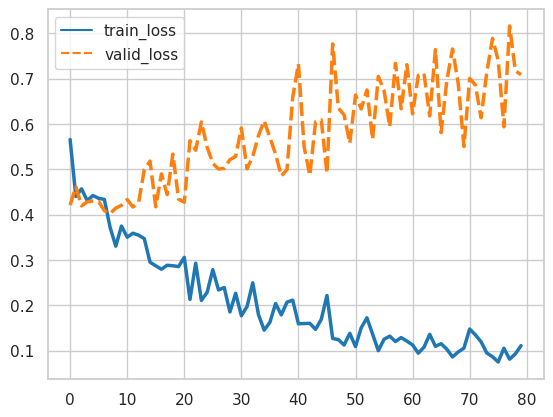

In [35]:
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

sns.lineplot(data=logs_dict, palette="tab10", linewidth=2.5)

## Evaluate

In [36]:
def evaluate(model, valid_dataloader, metrics=[('f1', f1_score),('precision', precision_score), ('recall', recall_score),('accuracy', accuracy_score)]):
    model.eval()

    y_trues = []
    y_hats = []

    with torch.no_grad():
        for batch in valid_dataloader:

            (ids, mask), y_true = batch
            y_hat = torch.softmax(model.forward(input_ids=ids, attention_mask=mask),dim=-1)

            for i in range(y_true.shape[0]):
                y_trues.append(int(y_true[i]))
                y_hats.append(1 if y_hat[i][0] < y_hat[i][1] else 0)

    scores = []

    for metric in metrics:
        scores.append((metric[0], metric[1](y_trues, y_hats)))        

    return scores

In [37]:
evaluate(model, valid_dataloader)

[('f1', 0.8136645962732919),
 ('precision', 0.8238993710691824),
 ('recall', 0.803680981595092),
 ('accuracy', 0.8402130492676432)]

In [38]:
def classify(tweet):
    ids = torch.tensor(tokenizer(tweet)['input_ids'])[None].to(device)
    return model.forward(input_ids=ids)

In [39]:
classify("Over 2 hundred families have become victims of my cookie-shop iniciative")

tensor([[ 0.6736, -1.0917]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Make predictions

In [40]:

predictions_df = pd.DataFrame()
for i, (ids, mask) in tqdm(eval_dataset):
    pred = model(input_ids=ids[None], attention_mask=mask[None])[0]
    y_hat = 1 if pred[0] < pred[1] else 0
    r = [int(i), y_hat]
    predictions_df = pd.concat([predictions_df, pd.DataFrame(np.array(r)[None,:], columns=['id', 'target'])])


100%|██████████| 3263/3263 [00:39<00:00, 81.92it/s]


In [41]:
predictions_df.target = predictions_df.target.astype(int)
predictions_df.id = predictions_df.id.astype(int)
predictions_df.head(20)

,id,target
0,0,0
0,2,1
0,3,1
0,9,1
0,11,1
0,12,0
0,21,0
0,22,0
0,27,0
0,29,0


In [42]:
predictions_df.to_csv('submission.csv', index=False)
print('Done!')

Done!
